# This notebook contains visualization and analysis of the Eagle dataset

## Import necessary packages

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import datetime

from scipy.optimize import curve_fit

## Get Eagle data

In [2]:
filepath = os.path.join('../data/', 'eagle_data.parquet')
eagle_df = pd.read_parquet(filepath)

In [3]:
eagle_df

,job_id,user,account,partition,qos,wallclock_req,nodes_req,processors_req,gpus_req,mem_req,submit_time,start_time,end_time,run_time,state,name,work_dir,submit_line
0,459053,user0001,account0001,partition001,Unknown,240.0,256,9216,0,0.0,2018-11-14 13:26:16,2018-11-14 13:26:17,2018-11-14 13:28:13,116.0,CANCELLED,name00000001,work_dir00000001,submit_line00000001
1,459058,user0001,account0001,partition001,Unknown,300.0,1,1,0,0.0,2018-11-14 13:26:16,2018-11-14 13:28:13,2018-11-14 13:28:13,0.0,CANCELLED,name00000002,work_dir00000001,submit_line00000001
2,459059,user0001,account0001,partition002,Unknown,36000.0,180,360,0,0.0,2018-11-14 13:26:16,2018-11-14 13:26:17,2018-11-14 13:28:13,116.0,CANCELLED,name00000003,work_dir00000001,submit_line00000001
3,459062,user0001,account0001,partition001,Unknown,300.0,1,1,0,0.0,2018-11-14 13:26:16,2018-11-14 13:28:13,2018-11-14 13:28:13,0.0,CANCELLED,name00000004,work_dir00000001,submit_line00000001
4,459061,user0001,account0001,partition001,Unknown,3660.0,180,360,0,0.0,2018-11-14 13:26:16,2018-11-14 13:26:17,2018-11-14 13:28:13,116.0,CANCELLED,name00000003,work_dir00000001,submit_line00000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11030372,11684761,user0867,account0072,partition008,normal,180000.0,1,32,0,85248.0,2023-02-22 00:36:12,NaT,NaT,0.0,PENDING,name02315561,work_dir02379655,submit_line00000512
11030373,11684762,user0867,account0072,partition008,normal,180000.0,1,32,0,85248.0,2023-02-22 00:36:14,NaT,NaT,0.0,PENDING,name02315561,work_dir02379656,submit_line00000512
11030374,11684763,user0867,account0072,partition008,normal,180000.0,1,32,0,85248.0,2023-02-22 00:41:27,NaT,NaT,0.0,PENDING,name02315561,work_dir02379657,submit_line00000512
11030375,11684764,user0867,account0072,partition008,normal,180000.0,1,32,0,85248.0,2023-02-22 00:44:35,NaT,NaT,0.0,PENDING,name02315561,work_dir02379658,submit_line00000512


## Count the number of jobs of each final state

In [4]:
eagle_df.state.value_counts()

COMPLETED        7390586
CANCELLED        1813244
FAILED            975478
TIMEOUT           803002
OUT_OF_MEMORY      20400
PENDING            14646
NODE_FAIL          12088
RUNNING              933
Name: state, dtype: int64

## Calculate key statistics

In [5]:
total_jobs = len(eagle_df)
total_users = len(eagle_df.user.unique())
total_accounts = len(eagle_df.account.unique())
median_runtime = eagle_df[eagle_df.state.isin(['COMPLETED','TIMEOUT'])].run_time.median() / 60
mean_runtime = eagle_df[eagle_df.state.isin(['COMPLETED','TIMEOUT'])].run_time.mean() / 3600
max_runtime = eagle_df[eagle_df.state.isin(['COMPLETED','TIMEOUT'])].run_time.max() / (60*60*24)
max_nodes = eagle_df[eagle_df.state.isin(['COMPLETED','TIMEOUT'])].nodes_req.max()

In [6]:
print(f'The Eagle dataset consists of {total_jobs:,} jobs run by {total_users} users and {total_accounts} accounts.\n' + 
      f'The median runtime is {median_runtime:0.1f} minutes and the average runtime is {mean_runtime:0.1f} hours.\n' +
      f'The longest job ran for {max_runtime:.0f} days and the maximum number of nodes used by a single job is {max_nodes}.')

The Eagle dataset consists of 11,030,377 jobs run by 936 users and 594 accounts.
The median runtime is 16.5 minutes and the average runtime is 2.9 hours.
The longest job ran for 13 days and the maximum number of nodes used by a single job is 2100.


## Prepare data for visualizations

In [7]:
def bin_node_hours(v):
    if v <= 4:
        return "short"
    elif (v > 4) and (v <= 48):
        return "medium"
    else: 
        return "long"

In [8]:
def bin_wallclock_req(v):
    if v <= .1:
        return 0 #"[0,6 m)"
    elif (v > .1) and (v <= 1):
        return 1 #"[6m,1 hr)"
    elif (v > 1) and (v <= 10):
        return 2 #"[1 hr,10 hr)"
    elif (v > 10) and (v <= 100):
        return 3 #"[10,100 hr)"\
    else:
        return 4

In [9]:
eagle_df['node_hours'] = eagle_df.run_time * eagle_df.nodes_req / 3600
eagle_df['node_hours_binned'] = eagle_df.node_hours.apply(bin_node_hours)
eagle_df['wc_ratio_req_vs_used'] = eagle_df.wallclock_req / eagle_df.run_time
eagle_df['wait_time'] = (eagle_df.start_time - eagle_df.submit_time).apply(lambda x: x.total_seconds())
eagle_df["wallclock_req_binned"] = (eagle_df.wallclock_req / 3600).apply(bin_wallclock_req)

In [10]:
filtered_df = eagle_df[eagle_df.state.isin(['COMPLETED','TIMEOUT'])]

# Visualizations

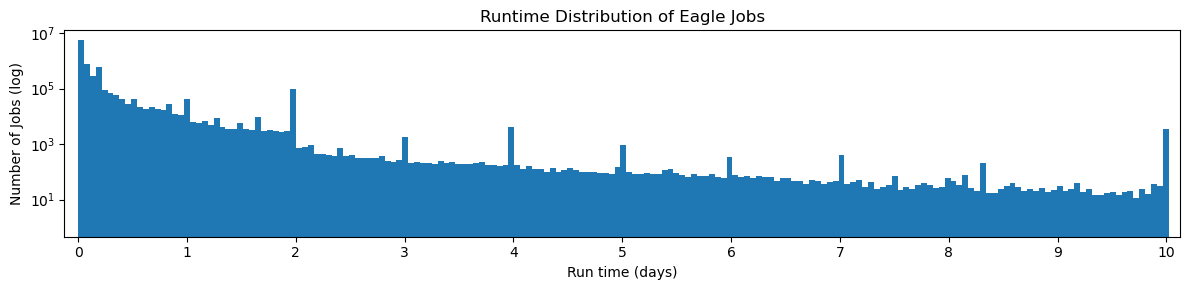

In [11]:
plt.figure(figsize=(12,3))
plt.hist(filtered_df['run_time'] / 3600, bins=240)
plt.xlim([-3,243])
plt.xticks([0,24,48,72,96,120,144,168,192,216,240], labels=[0,1,2,3,4,5,6,7,8,9,10])
plt.yscale('log')
plt.xlabel('Run time (days)')
plt.ylabel('Number of Jobs (log)')
plt.title('Runtime Distribution of Eagle Jobs')
plt.tight_layout()
plt.show()

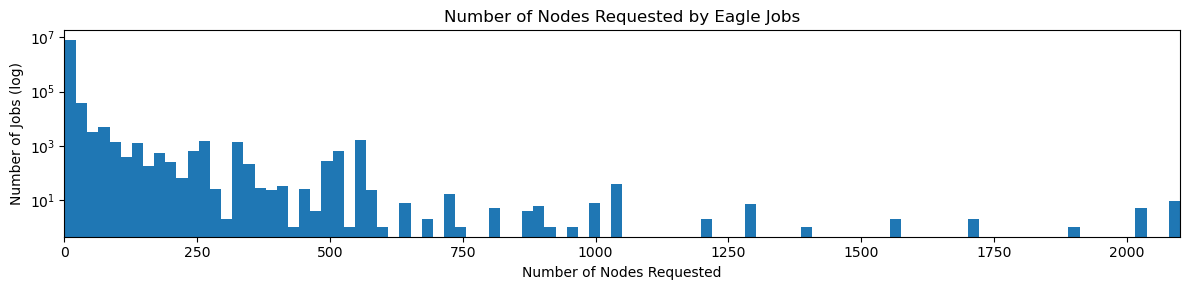

In [12]:
plt.figure(figsize=(12,3))
plt.hist(filtered_df['nodes_req'], bins=100)
plt.xlim([0,2100])
plt.yscale('log')
plt.xlabel('Number of Nodes Requested')
plt.ylabel('Number of Jobs (log)')
plt.title('Number of Nodes Requested by Eagle Jobs')
plt.tight_layout()
plt.show()

In [13]:
node_hours_binned_labels = ['short', 'medium', 'long']

num_jobs_by_job_length = dict()

for idx, grp in filtered_df.groupby('node_hours_binned'):
    num_jobs_by_job_length[idx] = len(grp)
    
num_jobs_by_job_length_df = pd.DataFrame(\
zip(num_jobs_by_job_length.keys(),num_jobs_by_job_length.values()),\
columns=['job_length', 'num_jobs'])

node_hours_by_job_length = dict()

for idx, grp in filtered_df.groupby('node_hours_binned'):
    node_hours_by_job_length[idx] = grp['node_hours'].sum()
    
node_hours_by_job_length_df = pd.DataFrame(\
zip(node_hours_by_job_length.keys(),node_hours_by_job_length.values()),\
columns=['job_length', 'node_hours'])

num_jobs_by_job_length_sorted = num_jobs_by_job_length_df.sort_values('job_length')
node_hours_by_job_length_sorted = node_hours_by_job_length_df.sort_values('job_length')

num_jobs_and_node_hours_by_job_length = pd.concat([num_jobs_by_job_length_sorted,node_hours_by_job_length_sorted['node_hours']],axis=1).sort_values('node_hours')
num_jobs_and_node_hours_by_job_length

,job_length,num_jobs,node_hours
2,short,6630090,3.631061e+06
1,medium,1352886,1.473025e+07
0,long,210612,4.042150e+07


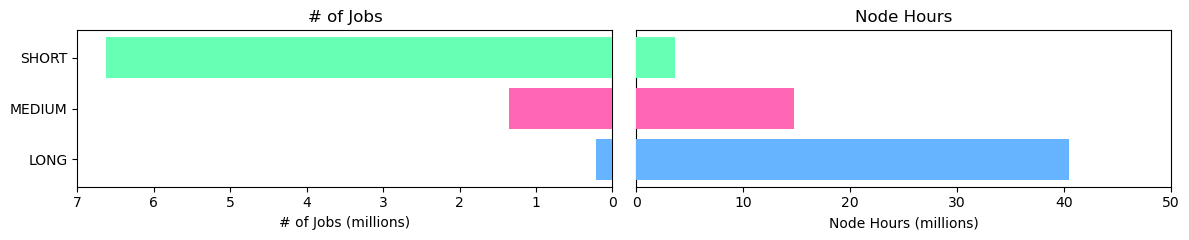

In [14]:
job_length = num_jobs_and_node_hours_by_job_length['job_length']

fig, axes = plt.subplots(figsize=(12,2.5), ncols=2, sharey=True)
fig.tight_layout()

colors = ['#66ffb3','#ff66b3','#66b3ff']
index = ['SHORT','MEDIUM','LONG']

axes[0].barh(index, num_jobs_and_node_hours_by_job_length['num_jobs'], align='center', color=colors, zorder=10)
axes[0].set_title("# of Jobs")
axes[0].invert_xaxis()
axes[0].yaxis.tick_left()

axes[1].barh(index, num_jobs_and_node_hours_by_job_length['node_hours'], align='center', color=colors, zorder=10)
axes[1].set_title("Node Hours")

labels_0 = ['0','1','2','3','4','5','6','7']
axes[0].set_xlabel("# of Jobs (millions)");
axes[0].set_xticks(list(range(0,7000001,1000000)))
axes[0].set_xticklabels(labels_0)

labels_1 = ['0','10','20','30','40','50']
axes[1].set_xlabel("Node Hours (millions)");
axes[1].set_xticks(list(range(0,50000001,10000000)))
axes[1].set_xticklabels(labels_1)
axes[1].tick_params(left=False)

plt.subplots_adjust(wspace=0.05, top=0.85, bottom=0.1, left=0.18, right=0.95)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

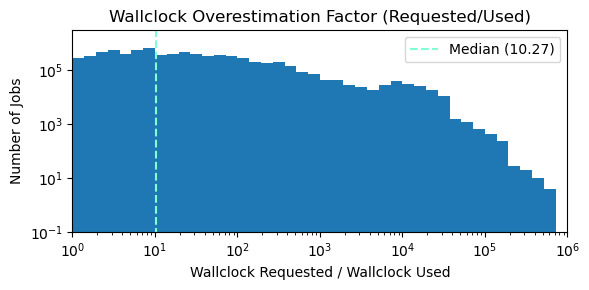

In [15]:
plt.figure(figsize=(6,3))
plt.hist(filtered_df[filtered_df.run_time > 0].wc_ratio_req_vs_used, bins=np.logspace(0,7,50))
med_factor = filtered_df[filtered_df.run_time > 0].wc_ratio_req_vs_used.median()
plt.vlines(med_factor,0,3000000, color = 'aquamarine', linestyle = '--', label=f"Median ({med_factor:.2f})")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim([1,1000000])
plt.ylim([.1,3000000])
plt.xlabel('Wallclock Requested / Wallclock Used')
plt.ylabel('Number of Jobs')
plt.title('Wallclock Overestimation Factor (Requested/Used)')
plt.tight_layout()
plt.show()

In [16]:
avg_wait_time = dict()
grp_len = dict()
for idx, grp in filtered_df.groupby('wallclock_req_binned'):
    grp_len[idx] = len(grp)
    avg_wait_time[idx] = grp.wait_time.mean() / 3600

In [17]:
avg_wc_req = dict()
for idx, grp in filtered_df.groupby('wallclock_req_binned'):
    avg_wc_req[idx] = grp.wallclock_req.mean() / 3600

In [18]:
def func(x,a,b):
    return a*x**b

In [19]:
x = np.array(list(avg_wc_req.values()))
y = np.array(list(avg_wait_time.values()))
popt, pcov = curve_fit(func, x, y)
popt

array([5.15850114, 0.53512049])

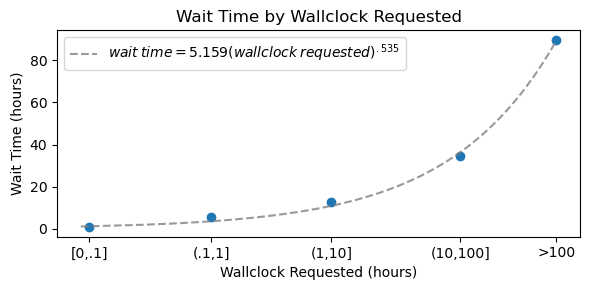

In [20]:
plt.figure(figsize=(6,3))

x_ = np.linspace(0.05,206,2000)
y_ = popt[0]*(x_**popt[1])

plt.scatter(x,y)
plt.plot(x_,y_,linestyle='--',color='grey',alpha=0.8,label='$wait\:time=5.159(wallclock\:requested)^{.535}$')

plt.xscale('log')
plt.xticks(x,labels=['[0,.1]','(.1,1]','(1,10]','(10,100]','>100'])
plt.xlabel('Wallclock Requested (hours)')
plt.ylabel('Wait Time (hours)')
plt.title('Wait Time by Wallclock Requested')
plt.minorticks_off()
plt.legend()

plt.tight_layout()
plt.show()